In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## restrict to wordy posts

df = pd.read_csv("train_test_data_v1.csv")
df = df.loc[(df.title_len > 40) | (df.body_len > 0)]

We make an outputs dataframe, and set a "principal" score, which is the principal axis from the PCA on these 3 features.

In [3]:
outputs = df[['score', 'num_comments', 'upvote_ratio']].astype(float)

In [4]:
outputs["norm_score"] = (outputs.score - outputs.score.mean()) / outputs.score.std()
outputs["norm_comments"] = (outputs.num_comments - outputs.num_comments.mean()) / outputs.num_comments.std()
outputs["norm_ratio"] = (outputs.upvote_ratio - outputs.upvote_ratio.mean()) / outputs.upvote_ratio.std()


outputs_final = outputs[['norm_score', 'norm_comments', 'norm_ratio']]
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(outputs_final)

PCA(n_components=3)

In [5]:
outputs["principal"] = pca.components_[0][0]*outputs.norm_score + pca.components_[0][1]*outputs.norm_comments + pca.components_[0][2]*outputs.norm_ratio 

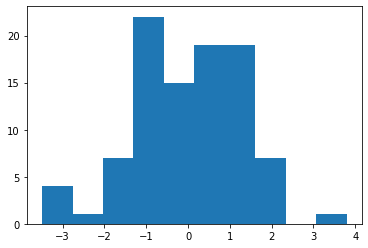

,Unnamed: 0,title_len,body_len,upvote_ratio,time,compound_score,num_early_comments,num_comments,num_top_comments,score,principal
4,l6x130,291,183,0.97,349.0,-0.5267,141,18325,69.0,222152.0,-3.487162
6,l6ekdz,110,0,0.96,795.0,0.2732,1625,15178,114.0,211182.0,-2.945107
8,l8c0u4,168,0,0.92,1133.0,0.5423,527,7171,38.0,210747.0,-1.731606
10,l6jobf,122,0,0.94,1017.0,0.6369,241,6973,117.0,195065.0,-1.701527
12,l90oq6,234,0,0.93,1024.0,0.8743,296,3858,120.0,185785.0,-1.179968
...,...,...,...,...,...,...,...,...,...,...,...
136,nfa216,37,5270,0.77,298.0,0.9942,16,573,203.0,633.0,2.231093
137,nfbwv5,68,875,0.79,379.0,0.9517,7,130,49.0,456.0,2.134443
138,nfjo84,52,0,0.80,684.0,0.0000,2,41,10.0,175.0,2.072955
139,nfkn43,73,0,0.85,722.0,-0.4215,11,99,35.0,137.0,1.694622


In [6]:
outputs_copy = outputs.copy()
df["principal"] = outputs_copy.principal
plt.hist(df.principal)
plt.show()
df

In [7]:
df.corr()['principal'].sort_values()

score                -0.888949
num_comments         -0.784367
upvote_ratio         -0.600587
num_early_comments   -0.595567
title_len            -0.247268
time                 -0.065905
num_top_comments      0.143630
compound_score        0.160695
body_len              0.223037
principal             1.000000
Name: principal, dtype: float64

We shrink the time values because they give my computer a headache.

In [8]:
## df['small_times'] = df.time_created/1000000

## plt.hist(df['score'])

We regress against time, because we don't want to be biased towards older posts.

In [9]:
## from sklearn.linear_model import LinearRegression

## slr = LinearRegression(copy_X = True)

## slr.fit(df['small_times'].values.reshape(-1,1), df['principal'].values)

Our final output variable is called popularity_score.

In [10]:
##b0 = slr.intercept_
## b1 = slr.coef_[0]

## df['popularity_score'] = df.principal - b0 - b1 * df.small_times

## define the classifiation here, check what proportion of posts are "good"
df['class'] = (df['principal'] > df['principal'].mean()+0.0*df['principal'].std())
df['class'] = df['class'].astype(int)
df['class'].mean()

0.4842105263157895

In [11]:
## code from K Nearest Neighbors Lecture, measuring accuracy of model
def get_acc(model,X,y):
    pred = model.predict(X)
    return np.sum(pred == y)/len(y)


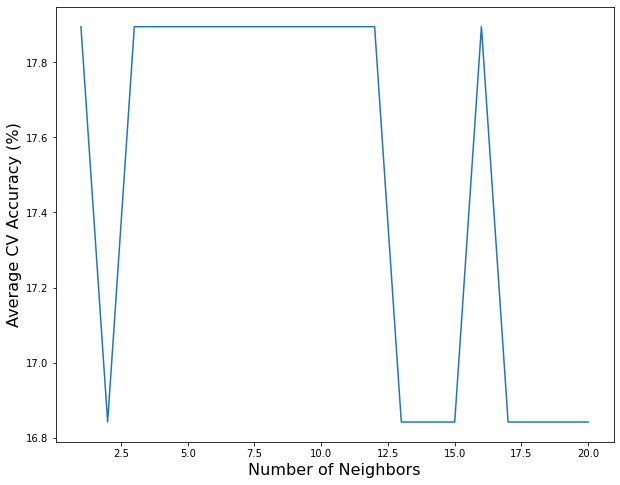

In [12]:
## KNN implementation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
## define data

kfold = StratifiedKFold(5,shuffle = True,random_state = 440)

max_neighbors = 20

X = df[['num_early_comments','body_len','title_len']].to_numpy()
y = df[['class']].to_numpy()


## Make an empty array to hold your cv accuracies here
accuracy = np.zeros((5,max_neighbors))

for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    i = 0;
    j = 0
    for i in range (0,max_neighbors):
        knn = KNeighborsClassifier(n_neighbors = i+1)
        knn.fit(X_train,y_train.ravel())
        accuracy[j][i] = get_acc(knn,X_test,y_test.ravel())
        i = i+1
    j = j+1

#Plot how the accuracy changes

plt.figure(figsize=(10,8))

## Plot the number of neighbors on the x
## plot the avg cross validation accuracy on the y
plt.plot(np.linspace(1,max_neighbors,num=max_neighbors),100*np.mean(accuracy,axis=0))

## Use these as your axes labels
plt.xlabel("Number of Neighbors", fontsize=16)
plt.ylabel("Average CV Accuracy (%)", fontsize=16)

plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=6)

clf = RandomForestClassifier(max_depth = 4, random_state=614)

clf.fit(X_train,y_train.ravel())

100*get_acc(clf,X_test,y_test.ravel())



82.75862068965517

In [14]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state = 100,max_depth=2)

plt.figure(figsize = (20,20))

## Plot the fitted tree
fig = tree_clf.fit(X_train, y_train)
## tree.plot_tree(fig,filled = True,max_depth=1)
## plt.show()
print(100*get_acc(fig,X_test,y_test.ravel()))

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=29)
confusion_matrix(y_test, fig.predict(X_test))

82.75862068965517


array([[21,  2],
       [ 3, 22]])

<Figure size 1440x1440 with 0 Axes>

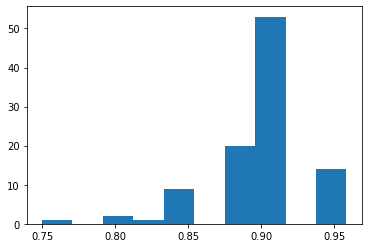

0.89375

In [15]:
n=100
accuracy = np.zeros(n)

for i in range(0,n):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=i)
    fig = tree_clf.fit(X_train, y_train)
    accuracy[i] = get_acc(fig,X_test,y_test.ravel())
plt.hist(accuracy)
plt.show()
accuracy.mean()